In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
data = pd.read_csv('../chap07/data/SBUX.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

In [3]:
X_all = data.iloc[:, :-1].values   # (N, F)
y_all = data.iloc[:,  5:6].values  # (N, 1)  

split = 200  # train/test 분할 
X_train_raw, X_test_raw = X_all[:split], X_all[split:]
y_train_raw, y_test_raw = y_all[:split], y_all[split:]

In [4]:
##입력 특징 x는 평균 분산이 제각각이라 표준화
##타깃(회귀)는 범위를 [0,1]로 고정하면 출력층/손실설정과 매칭이 쉬움

ss = StandardScaler()
ms = MinMaxScaler()

X_train = ss.fit_transform(X_train_raw)
X_test  = ss.transform(X_test_raw)

y_train = ms.fit_transform(y_train_raw)
y_test  = ms.transform(y_test_raw)

In [5]:
# 2) 윈도우 생성 (T=20)
# -----------------------------
def make_windows(X2d, y2d, T, horizon=1):
    # X2d: (N,F), y2d: (N,1)
    Xw, yw = [], []
    N = len(X2d)
    last = N - T - (horizon - 1)
    for i in range(last):
        Xw.append(X2d[i:i+T])               # (T,F)
        yw.append(y2d[i+T+(horizon-1), 0])  # 스칼라
    Xw = np.asarray(Xw)                      # (B, T, F)
    yw = np.asarray(yw).reshape(-1, 1)       # (B, 1)
    return Xw, yw

T = 20
X_train_w, y_train_w = make_windows(X_train, y_train, T=T, horizon=1)
X_test_w,  y_test_w  = make_windows(X_test,  y_test,  T=T, horizon=1)

# 텐서 변환
Xtr = torch.tensor(X_train_w, dtype=torch.float32, device=device)  # (Btr,T,F)
ytr = torch.tensor(y_train_w, dtype=torch.float32, device=device)  # (Btr,1)
Xte = torch.tensor(X_test_w,  dtype=torch.float32, device=device)  # (Bte,T,F)
yte = torch.tensor(y_test_w,  dtype=torch.float32, device=device)  # (Bte,1)

Btr, T_, F = Xtr.shape

In [6]:
class GRU(nn.Module):
    def __init__(self, input_size:int, hidden_size:int =128,
                 num_layers: int = 1, bidirectional: bool = False):
        super().__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional=bidirectional)
        self.head = nn.Sequential(
            nn.Linear(self.hidden_size * self.num_directions, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )
    
    def forward(self, x):
        # x -> (B, T, D)
        output, hn = self.gru(x) # 
        if self.bidirectional:
            last = torch.cat([hn[-2], hn[-1]], dim=1)  # (B, 2H)
        else:
            last = hn[-1]                              # (B, H)
        y_hat = self.head(last)                        # (B, 1)
        return y_hat

In [7]:
model = GRU(input_size=5, hidden_size=32, num_layers=1, bidirectional=False).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 1000

In [8]:
model.train()
for ep in range(1, num_epochs+1):
    optimizer.zero_grad()
    pred = model(Xtr)           # (Btr,1)
    loss = criterion(pred, ytr)
    loss.backward()
    # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    if ep % 100 == 0 :
        model.eval()
        with torch.no_grad():
            val_pred = model(Xte)
            val_loss = criterion(val_pred, yte).item()
        model.train()
        print(f"[{ep:3d}/{num_epochs}] train_loss={loss.item():.6f}  val_loss={val_loss:.6f}")

[100/1000] train_loss=0.024629  val_loss=0.015243
[200/1000] train_loss=0.021255  val_loss=0.012837
[300/1000] train_loss=0.018885  val_loss=0.010532
[400/1000] train_loss=0.016799  val_loss=0.010407
[500/1000] train_loss=0.015383  val_loss=0.013423
[600/1000] train_loss=0.014701  val_loss=0.014706
[700/1000] train_loss=0.014128  val_loss=0.014724
[800/1000] train_loss=0.013540  val_loss=0.014695
[900/1000] train_loss=0.012884  val_loss=0.014838
[1000/1000] train_loss=0.012122  val_loss=0.015429


In [9]:
X_all_ss = ss.transform(X_all)          # (N,F)
y_all_ms = ms.transform(y_all)          # (N,1)

X_all_w, y_all_w = make_windows(X_all_ss, y_all_ms, T=T, horizon=1)  # (Ball,T,F),(Ball,1)

Xall_t = torch.tensor(X_all_w, dtype=torch.float32, device=device)
model.eval()
with torch.no_grad():
    yhat_all_ms = model(Xall_t).cpu().numpy()  # (Ball,1)

# 원스케일로 복원
yhat_all = ms.inverse_transform(yhat_all_ms)   # (Ball,1)
y_true_all = y_all                             # (N,1) 원 스케일

# 예측을 원래 시계열 위치에 맞추기
# 윈도우 i의 예측은 시점 (i+T) 에 해당 → 처음 T 구간은 예측 없음
N = len(y_true_all)
pred_series = np.full((N, 1), np.nan)
pred_series[T:] = yhat_all  # 인덱스 T..N-1




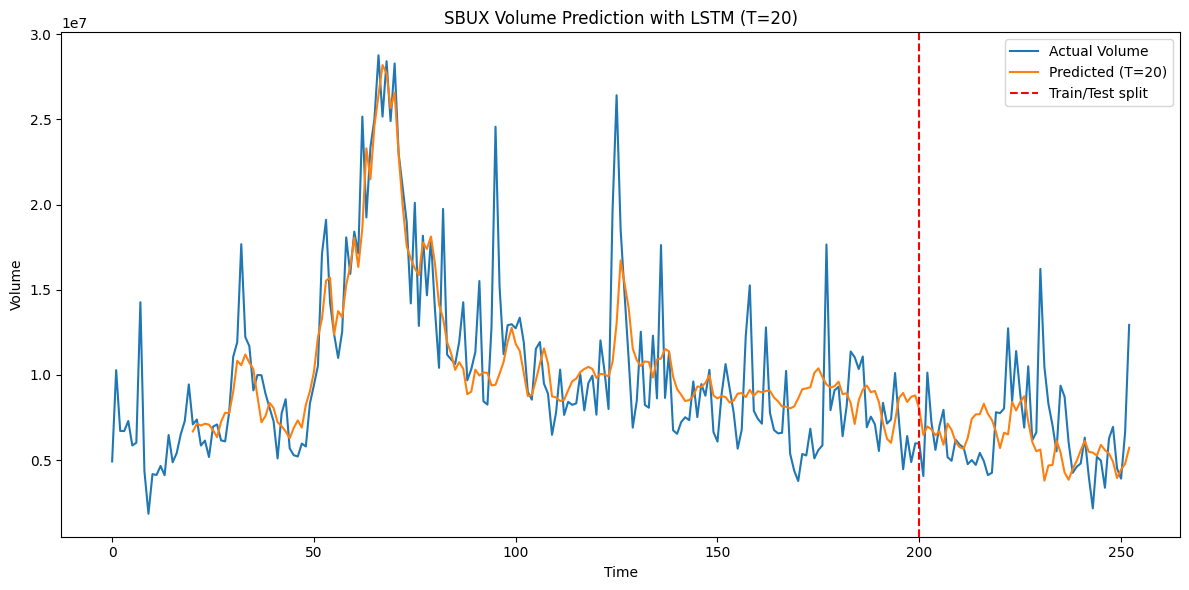

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_true_all, label='Actual Volume')
plt.plot(pred_series, label=f'Predicted (T={T})')

# train/test 경계선 (예측 배열 기준으로는 split 지점에 선을 그리면 됨)
plt.axvline(x=split, c='r', linestyle='--', label='Train/Test split')

plt.title('SBUX Volume Prediction with LSTM (T=20)')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()
plt.tight_layout()
plt.show()